In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import tensorflow as tf
from keras.applications.mobilenet_v2 import MobileNetV2

Using TensorFlow backend.


In [6]:
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.applications import imagenet_utils
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam,Adadelta
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout
from IPython.display import Image
from keras.optimizers import Adam
from keras.initializers import glorot_normal
from keras.callbacks.callbacks import ModelCheckpoint

In [105]:
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch index (and number..) with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) # not +1 because we have epoch 0 somewhy
    print("Minimum validation loss reached in epoch {}, with validation-set accuracy of {}".format(min_epoch, model_hist.history['val_accuracy'][min_epoch])) # and here not minus 1
    return min_epoch

In [7]:
image_generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.2,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

test_generator = ImageDataGenerator(rescale=1./255)

In [8]:
data_training_dir = r"drive/My Drive/Colab Notebooks/data1a/training"
data_validation_dir = r"drive/My Drive/Colab Notebooks/data1a/validation"
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
CLASS_NAMES = ['okay','damaged']

In [9]:
train_data_gen = image_generator.flow_from_directory(directory=data_training_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASS_NAMES,
                                                     class_mode='categorical')

validation_data_gen = test_generator.flow_from_directory(directory=data_validation_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASS_NAMES,
                                                     batch_size = 460,
                                                     class_mode='categorical',
                                                     shuffle=False)

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [10]:
base_model = MobileNetV2(input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet')

In [18]:
x=base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512,activation='relu')(x)
preds = Dense(2,activation='softmax')(x) #final layer with softmax activation

In [19]:
model = Model(inputs=base_model.input,outputs=preds)

In [20]:
for layer in model.layers:
    layer.trainable=False

for layer in model.layers[-5:]:
  layer.trainable = True

for layer in model.layers:
  if layer.trainable:
    print(layer.name)

global_average_pooling2d_2
dense_4
dense_5
dense_6
dense_7


In [21]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [22]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
step_size_validation = validation_data_gen.n // validation_data_gen.batch_size

loss0, accuracy0 = model.evaluate_generator(validation_data_gen, steps=step_size_validation)
loss0, accuracy0

(0.6697659492492676, 0.5565217137336731)

In [24]:
# Training the model on 10 epochs first to check our hyperparameters and see if we need to tune them.
step_size_train = train_data_gen.n // train_data_gen.batch_size
history = model.fit_generator(generator=train_data_gen,
                   steps_per_epoch=step_size_train,
                  validation_data=validation_data_gen,
                   epochs=20)

Epoch 1/20
28/28 [==============================] - 29s 1s/step - loss: 0.5467 - accuracy: 0.7731 - val_loss: 2.0031 - val_accuracy: 0.5261
Epoch 2/20
28/28 [==============================] - 27s 969ms/step - loss: 0.2747 - accuracy: 0.8885 - val_loss: 0.3783 - val_accuracy: 0.8196
Epoch 3/20
28/28 [==============================] - 27s 973ms/step - loss: 0.2652 - accuracy: 0.8896 - val_loss: 0.8043 - val_accuracy: 0.7022
Epoch 4/20
28/28 [==============================] - 27s 956ms/step - loss: 0.2401 - accuracy: 0.8998 - val_loss: 0.5104 - val_accuracy: 0.7587
Epoch 5/20
28/28 [==============================] - 27s 970ms/step - loss: 0.2323 - accuracy: 0.9020 - val_loss: 0.7014 - val_accuracy: 0.7348
Epoch 6/20
28/28 [==============================] - 27s 971ms/step - loss: 0.2194 - accuracy: 0.9127 - val_loss: 0.8085 - val_accuracy: 0.6283
Epoch 7/20
28/28 [==============================] - 27s 951ms/step - loss: 0.2292 - accuracy: 0.9060 - val_loss: 0.7071 - val_accuracy: 0.7304
Ep

(0.5059906661510467, 0.9481097042560578)


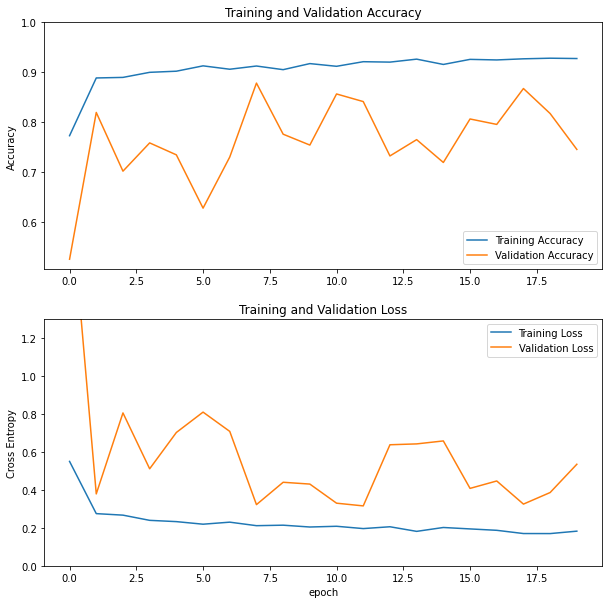

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
print(plt.ylim())
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

so, our validation set accuracy and loss are pretty jumpy but on our training set they are not, so I would think maybe i picked too high batch size because the model finds it hard to generalize to our validation-set.
But batch_size is only 64 and since the validation loss goes up after 5 epochs indicates maybe our model is overfitted.
So, now, before I am working on reducing the overfitting, I will try to reduce the batch_size and train few of the top layers of the base_model.

In [26]:
len(base_model.layers)

155

In [27]:
model.trainable = True

fine_tune_at = 101

for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

In [28]:
BATCH_SIZE = 32
train_data_gen = image_generator.flow_from_directory(directory=data_training_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASS_NAMES,
                                                     class_mode='categorical')

# Training the model on 10 epochs first to check our hyperparameters and see if we need to tune them.
step_size_train = train_data_gen.n // train_data_gen.batch_size
history_fine = model.fit_generator(train_data_gen,
                         epochs=40,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_data_gen)

Found 1840 images belonging to 2 classes.
Epoch 20/40
58/58 [==============================] - 30s 518ms/step - loss: 0.2008 - accuracy: 0.9217 - val_loss: 0.4856 - val_accuracy: 0.7739
Epoch 21/40
58/58 [==============================] - 28s 491ms/step - loss: 0.2138 - accuracy: 0.9125 - val_loss: 0.4557 - val_accuracy: 0.7630
Epoch 22/40
58/58 [==============================] - 29s 495ms/step - loss: 0.1882 - accuracy: 0.9234 - val_loss: 0.3619 - val_accuracy: 0.8326
Epoch 23/40
58/58 [==============================] - 29s 501ms/step - loss: 0.1885 - accuracy: 0.9223 - val_loss: 0.2735 - val_accuracy: 0.8935
Epoch 24/40
58/58 [==============================] - 28s 488ms/step - loss: 0.1883 - accuracy: 0.9272 - val_loss: 0.3397 - val_accuracy: 0.8391
Epoch 25/40
58/58 [==============================] - 28s 489ms/step - loss: 0.1735 - accuracy: 0.9310 - val_loss: 0.3621 - val_accuracy: 0.8478
Epoch 26/40
58/58 [==============================] - 29s 492ms/step - loss: 0.1689 - accuracy:

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

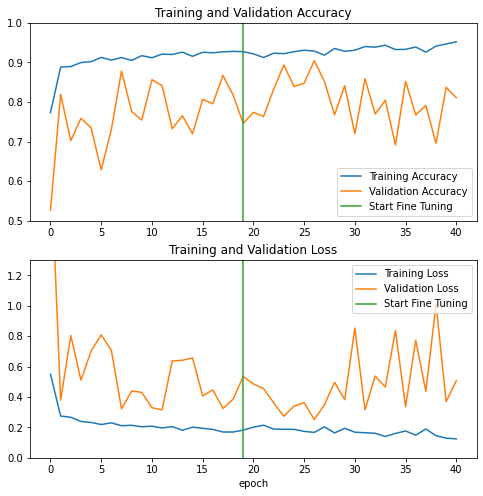

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([19,19],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.3])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [107]:
optimal_epoch(history)

Minimum validation loss reached in epoch 26, with validation-set accuracy of 0.904347836971283


26

In [ ]:
# model.save_weights(filepath='drive/My Drive/Colab Notebooks/weights_no_regul.h5')
# model.load_weights('drive/My Drive/Colab Notebooks/weights_no_regul.h5')

In [31]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(2,activation='softmax')(x) #final layer with softmax activation

In [32]:
model_with_dropout = Model(inputs=base_model.input,outputs=preds)

In [33]:
for layer in model_with_dropout.layers:
    layer.trainable=False

for layer in model_with_dropout.layers[-8:]:
  layer.trainable = True

for layer in model_with_dropout.layers:
  if layer.trainable:
    print(layer.name)

global_average_pooling2d_3
dense_8
dropout_1
dense_9
dropout_2
dense_10
dropout_3
dense_11


In [34]:
model_with_dropout.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
step_size_validation = validation_data_gen.n // validation_data_gen.batch_size

loss0_with_dropout, accuracy0_with_dropout = model_with_dropout.evaluate_generator(validation_data_gen, steps=step_size_validation)

In [36]:
loss0_with_dropout, accuracy0_with_dropout

(0.7592056393623352, 0.44999998807907104)

In [38]:
step_size_train = train_data_gen.n // train_data_gen.batch_size
step_size_validation = validation_data_gen.n // validation_data_gen.batch_size
history_with_dropout = model_with_dropout.fit_generator(generator=train_data_gen,
                   steps_per_epoch=step_size_train,
                  validation_data=validation_data_gen,
                   epochs=20)

Epoch 1/20
57/57 [==============================] - 29s 514ms/step - loss: 0.3342 - accuracy: 0.8628 - val_loss: 0.6821 - val_accuracy: 0.6935
Epoch 2/20
57/57 [==============================] - 28s 500ms/step - loss: 0.3193 - accuracy: 0.8744 - val_loss: 0.4664 - val_accuracy: 0.7630
Epoch 3/20
57/57 [==============================] - 28s 499ms/step - loss: 0.3072 - accuracy: 0.8684 - val_loss: 0.8141 - val_accuracy: 0.6565
Epoch 4/20
57/57 [==============================] - 28s 499ms/step - loss: 0.2872 - accuracy: 0.8888 - val_loss: 0.9418 - val_accuracy: 0.6152
Epoch 5/20
57/57 [==============================] - 29s 501ms/step - loss: 0.2896 - accuracy: 0.8838 - val_loss: 1.0855 - val_accuracy: 0.6065
Epoch 6/20
57/57 [==============================] - 29s 505ms/step - loss: 0.2695 - accuracy: 0.8955 - val_loss: 0.3803 - val_accuracy: 0.8196
Epoch 7/20
57/57 [==============================] - 29s 503ms/step - loss: 0.2625 - accuracy: 0.9027 - val_loss: 0.5184 - val_accuracy: 0.7283

(0.5912725895643234, 0.9267535835504532)


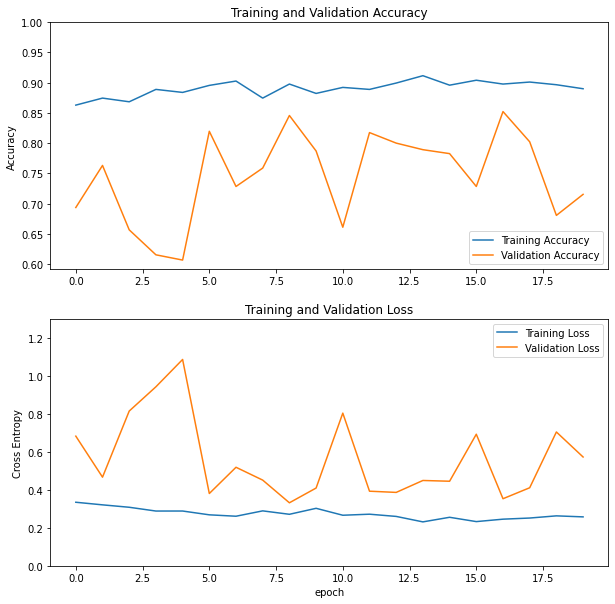

In [39]:
acc_with_dropout = history_with_dropout.history['accuracy']
val_acc_with_dropout = history_with_dropout.history['val_accuracy']

loss_with_dropout = history_with_dropout.history['loss']
val_loss_with_dropout = history_with_dropout.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc_with_dropout, label='Training Accuracy')
plt.plot(val_acc_with_dropout, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
print(plt.ylim())
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_with_dropout, label='Training Loss')
plt.plot(val_loss_with_dropout, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning - model with dropout

In [40]:
model_with_dropout.trainable = True

fine_tune_at = 101

for layer in model_with_dropout.layers[:fine_tune_at]:
  layer.trainable = False

In [41]:
step_size_train = train_data_gen.n // train_data_gen.batch_size
history_fine_with_dropout = model_with_dropout.fit_generator(train_data_gen,
                         epochs=40,
                         initial_epoch=history_with_dropout.epoch[-1],
                         validation_data=validation_data_gen)

Epoch 20/40
58/58 [==============================] - 30s 517ms/step - loss: 0.2406 - accuracy: 0.9011 - val_loss: 0.3701 - val_accuracy: 0.8109
Epoch 21/40
58/58 [==============================] - 29s 496ms/step - loss: 0.2536 - accuracy: 0.8995 - val_loss: 0.3760 - val_accuracy: 0.8239
Epoch 22/40
58/58 [==============================] - 29s 495ms/step - loss: 0.2473 - accuracy: 0.9049 - val_loss: 0.5360 - val_accuracy: 0.7370
Epoch 23/40
58/58 [==============================] - 29s 507ms/step - loss: 0.2475 - accuracy: 0.8935 - val_loss: 0.4334 - val_accuracy: 0.8000
Epoch 24/40
58/58 [==============================] - 29s 498ms/step - loss: 0.2259 - accuracy: 0.9060 - val_loss: 0.3583 - val_accuracy: 0.8326
Epoch 25/40
58/58 [==============================] - 29s 498ms/step - loss: 0.2240 - accuracy: 0.9201 - val_loss: 0.5546 - val_accuracy: 0.7609
Epoch 26/40
58/58 [==============================] - 29s 501ms/step - loss: 0.2206 - accuracy: 0.9065 - val_loss: 0.3200 - val_accuracy:

In [42]:
acc_with_dropout += history_fine_with_dropout.history['accuracy']
val_acc_with_dropout += history_fine_with_dropout.history['val_accuracy']

loss_with_dropout += history_fine_with_dropout.history['loss']
val_loss_with_dropout += history_fine_with_dropout.history['val_loss']

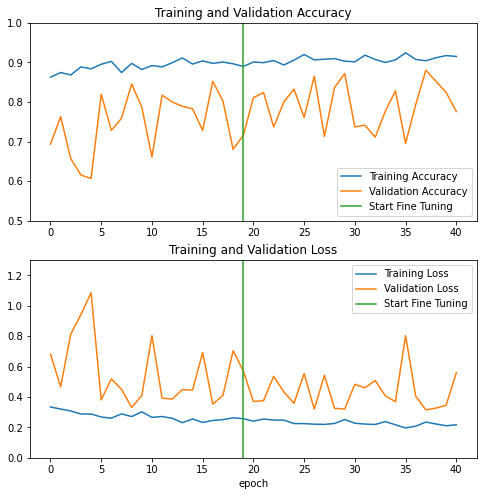

In [43]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_with_dropout, label='Training Accuracy')
plt.plot(val_acc_with_dropout, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([19,19],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_with_dropout, label='Training Loss')
plt.plot(val_loss_with_dropout, label='Validation Loss')
plt.ylim([0, 1.3])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [106]:
optimal_epoch(history_with_dropout)

Minimum validation loss reached in epoch 37, with validation-set accuracy of 0.8804348111152649


37

# Reducing the network’s capacity

In [45]:
BATCH_SIZE = 32
train_data_gen = image_generator.flow_from_directory(directory=data_training_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASS_NAMES,
                                                     class_mode='categorical')

validation_data_gen = test_generator.flow_from_directory(directory=data_validation_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASS_NAMES,
                                                     batch_size = 460,
                                                     class_mode='categorical',
                                                     shuffle=False)

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [46]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
preds = Dense(2,activation='softmax')(x) #final layer with softmax activation

In [47]:
model_small_capacity = Model(inputs=base_model.input,outputs=preds)

In [48]:
for layer in model.layers:
    layer.trainable=False

for layer in model.layers[-3:]:
  layer.trainable = True

for layer in model.layers:
  if layer.trainable:
    print(layer.name)

dense_5
dense_6
dense_7


In [50]:
model_small_capacity.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [51]:
step_size_validation = validation_data_gen.n // validation_data_gen.batch_size

loss0, accuracy0 = model.evaluate_generator(validation_data_gen, steps=step_size_validation)
loss0, accuracy0

(0.508144199848175, 0.810869574546814)

In [52]:
# Training the model on 10 epochs first to check our hyperparameters and see if we need to tune them.
step_size_train = train_data_gen.n // train_data_gen.batch_size
history_small_capacity = model_small_capacity.fit_generator(generator=train_data_gen,
                   steps_per_epoch=step_size_train,
                  validation_data=validation_data_gen,
                   epochs=20)

Epoch 1/20
57/57 [==============================] - 32s 559ms/step - loss: 0.4424 - accuracy: 0.8136 - val_loss: 1.0912 - val_accuracy: 0.6109
Epoch 2/20
57/57 [==============================] - 28s 485ms/step - loss: 0.2975 - accuracy: 0.8816 - val_loss: 0.7775 - val_accuracy: 0.6630
Epoch 3/20
57/57 [==============================] - 28s 489ms/step - loss: 0.2888 - accuracy: 0.8761 - val_loss: 0.6985 - val_accuracy: 0.6826
Epoch 4/20
57/57 [==============================] - 28s 489ms/step - loss: 0.2418 - accuracy: 0.9021 - val_loss: 0.6623 - val_accuracy: 0.7087
Epoch 5/20
57/57 [==============================] - 28s 494ms/step - loss: 0.2595 - accuracy: 0.8899 - val_loss: 0.4963 - val_accuracy: 0.7674
Epoch 6/20
57/57 [==============================] - 28s 488ms/step - loss: 0.2595 - accuracy: 0.8977 - val_loss: 0.4024 - val_accuracy: 0.8043
Epoch 7/20
57/57 [==============================] - 28s 498ms/step - loss: 0.2474 - accuracy: 0.8920 - val_loss: 0.3411 - val_accuracy: 0.8500

(0.5949492514133453, 0.9451966226100922)


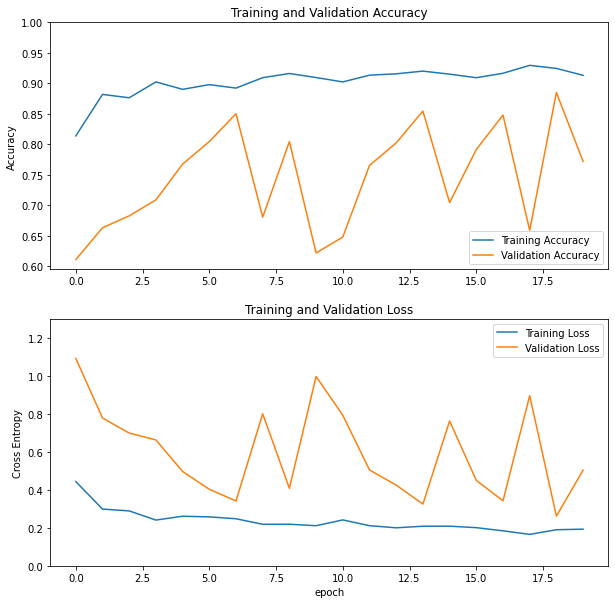

In [112]:
acc_small_capacity = history_small_capacity.history['accuracy']
val_acc_small_capacity = history_small_capacity.history['val_accuracy']

loss_small_capacity = history_small_capacity.history['loss']
val_loss_small_capacity = history_small_capacity.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc_small_capacity, label='Training Accuracy')
plt.plot(val_acc_small_capacity, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
print(plt.ylim())
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_small_capacity, label='Training Loss')
plt.plot(val_loss_small_capacity, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [113]:
optimal_epoch(history_small_capacity)

Minimum validation loss reached in epoch 18, with validation-set accuracy of 0.884782612323761


18

I will not try to tune this method of "regularization" because from the first graph I can see that the model is not complex enough to generalize so it is a waste of time.

# L2 Regularization

In [57]:
from keras import regularizers

In [58]:
x=base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
preds = Dense(2, activation='softmax')(x) #final layer with softmax activation

In [60]:
model_with_reg = Model(inputs=base_model.input,outputs=preds)

In [61]:
for layer in model_with_reg.layers:
    layer.trainable=False

for layer in model_with_reg.layers[-5:]:
  layer.trainable = True

for layer in model_with_reg.layers:
  if layer.trainable:
    print(layer.name)

global_average_pooling2d_5
dense_14
dense_15
dense_16
dense_17


In [65]:
model_with_reg.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [66]:
step_size_validation = validation_data_gen.n // validation_data_gen.batch_size

loss0, accuracy0 = model_with_reg.evaluate_generator(validation_data_gen, steps=step_size_validation)
loss0, accuracy0

(3.5446956157684326, 0.502173900604248)

In [67]:
# Training the model on 10 epochs first to check our hyperparameters and see if we need to tune them.
step_size_train = train_data_gen.n // train_data_gen.batch_size
history_with_reg = model_with_reg.fit_generator(generator=train_data_gen,
                   steps_per_epoch=step_size_train,
                  validation_data=validation_data_gen,
                   epochs=20)

Epoch 1/20
57/57 [==============================] - 31s 541ms/step - loss: 2.7062 - accuracy: 0.7942 - val_loss: 2.5083 - val_accuracy: 0.6609
Epoch 2/20
57/57 [==============================] - 29s 505ms/step - loss: 1.6882 - accuracy: 0.8722 - val_loss: 1.5799 - val_accuracy: 0.7391
Epoch 3/20
57/57 [==============================] - 29s 514ms/step - loss: 1.1768 - accuracy: 0.9049 - val_loss: 1.1486 - val_accuracy: 0.8326
Epoch 4/20
57/57 [==============================] - 29s 510ms/step - loss: 0.9587 - accuracy: 0.8761 - val_loss: 1.1492 - val_accuracy: 0.6478
Epoch 5/20
57/57 [==============================] - 29s 504ms/step - loss: 0.7621 - accuracy: 0.8938 - val_loss: 1.0129 - val_accuracy: 0.7587
Epoch 6/20
57/57 [==============================] - 29s 511ms/step - loss: 0.6321 - accuracy: 0.8982 - val_loss: 1.1488 - val_accuracy: 0.7304
Epoch 7/20
57/57 [==============================] - 29s 510ms/step - loss: 0.5593 - accuracy: 0.8927 - val_loss: 0.9319 - val_accuracy: 0.7261

(0.6342469841241837, 0.9329869955778122)


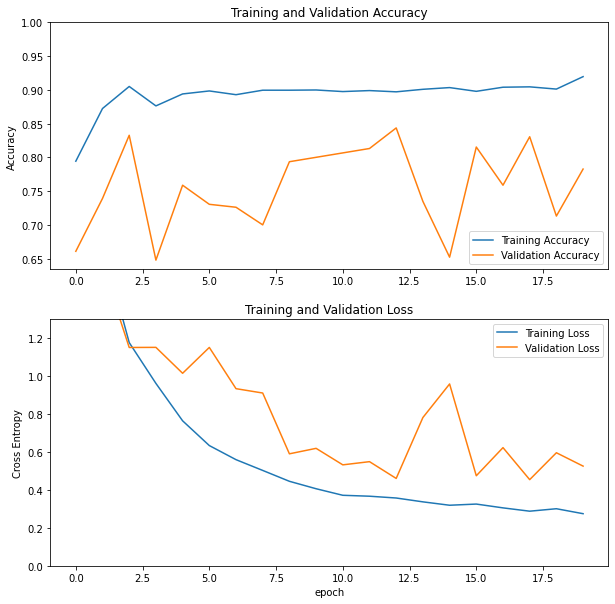

In [68]:
acc_with_reg = history_with_reg.history['accuracy']
val_acc_with_reg = history_with_reg.history['val_accuracy']

loss_with_reg = history_with_reg.history['loss']
val_loss_with_reg = history_with_reg.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc_with_reg, label='Training Accuracy')
plt.plot(val_acc_with_reg, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
print(plt.ylim())
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_with_reg, label='Training Loss')
plt.plot(val_loss_with_reg, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning - model with regularization

In [69]:
model_with_reg.trainable = True

fine_tune_at = 101

for layer in model_with_reg.layers[:fine_tune_at]:
  layer.trainable = False

In [72]:
BATCH_SIZE = 8
train_data_gen = image_generator.flow_from_directory(directory=data_training_dir,
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = CLASS_NAMES,
                                                     class_mode='categorical')

# Training the model on 10 epochs first to check our hyperparameters and see if we need to tune them.
step_size_train = train_data_gen.n // train_data_gen.batch_size
history_fine_with_reg = model_with_reg.fit_generator(train_data_gen,
                         epochs=40,
                         initial_epoch=history_with_reg.epoch[-1],
                         validation_data=validation_data_gen)

Found 1840 images belonging to 2 classes.
Epoch 20/40
230/230 [==============================] - 33s 142ms/step - loss: 0.3255 - accuracy: 0.8870 - val_loss: 0.6586 - val_accuracy: 0.6348
Epoch 21/40
230/230 [==============================] - 32s 138ms/step - loss: 0.3127 - accuracy: 0.8832 - val_loss: 0.7860 - val_accuracy: 0.6761
Epoch 22/40
230/230 [==============================] - 32s 138ms/step - loss: 0.3098 - accuracy: 0.8859 - val_loss: 0.4589 - val_accuracy: 0.8152
Epoch 23/40
230/230 [==============================] - 32s 138ms/step - loss: 0.3405 - accuracy: 0.8696 - val_loss: 0.4894 - val_accuracy: 0.7783
Epoch 24/40
230/230 [==============================] - 32s 138ms/step - loss: 0.3225 - accuracy: 0.8804 - val_loss: 0.6142 - val_accuracy: 0.6913
Epoch 25/40
230/230 [==============================] - 32s 138ms/step - loss: 0.3313 - accuracy: 0.8821 - val_loss: 0.4921 - val_accuracy: 0.7630
Epoch 26/40
230/230 [==============================] - 32s 140ms/step - loss: 0.32

In [73]:
acc_with_reg += history_fine_with_reg.history['accuracy']
val_acc_with_reg += history_fine_with_reg.history['val_accuracy']

loss_with_reg += history_fine_with_reg.history['loss']
val_loss_with_reg += history_fine_with_reg.history['val_loss']

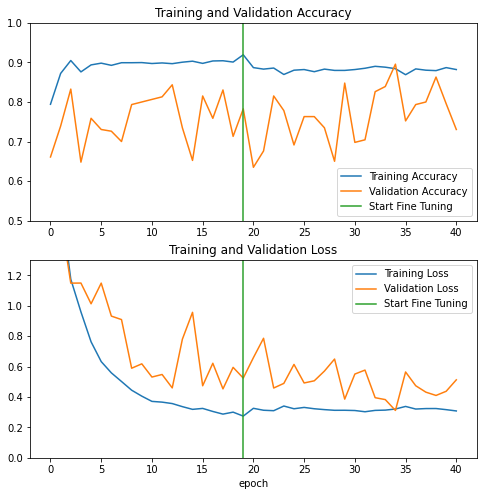

In [74]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_with_reg, label='Training Accuracy')
plt.plot(val_acc_with_reg, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([19,19],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_with_reg, label='Training Loss')
plt.plot(val_loss_with_reg, label='Validation Loss')
plt.ylim([0, 1.3])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [114]:
optimal_epoch(history_with_reg)

Minimum validation loss reached in epoch 34, with validation-set accuracy of 0.895652174949646


34

# Early Stopping

We can early-stop each of the models above, all we need to do is just train them with number of epochs = optimal_epoch of this model's history.

In [77]:
def test_model(model, train_generator, epoch_stop):
    '''
    Function to get new model after training it
    on the full training data with the optimal number of epochs.
    
    Output:
        new model
    '''
    model.fit_generator(train_generator
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE)
    return model

I will not continue with early stopping since it is pretty straightforward and easy to see the results of it without implementation...

# In Conclusion

## Loss

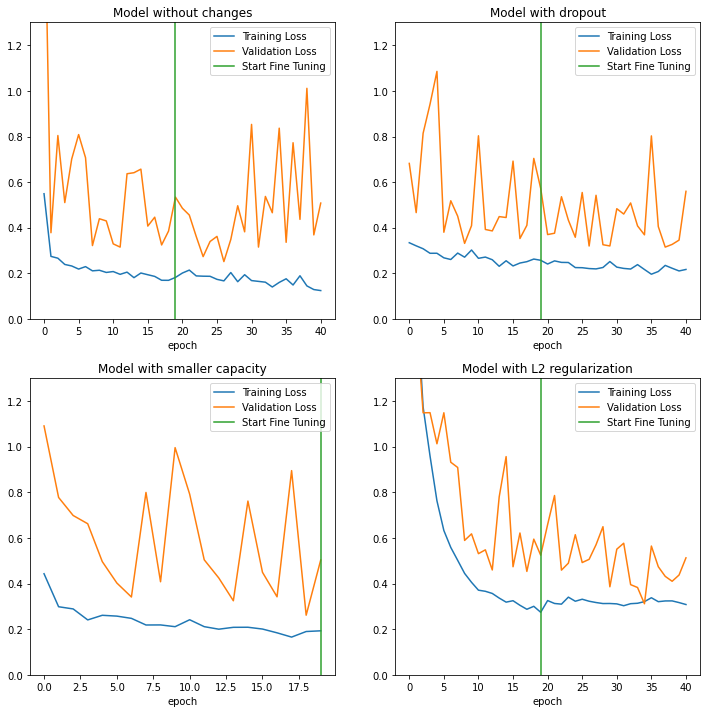

In [129]:
plt.figure(figsize=(12,12))
plt.subplot(2, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.3])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model without changes')
plt.xlabel('epoch')

plt.subplot(2, 2, 2)
plt.plot(loss_with_dropout, label='Training Loss')
plt.plot(val_loss_with_dropout, label='Validation Loss')
plt.ylim([0, 1.3])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model with dropout')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(loss_small_capacity, label='Training Loss')
plt.plot(val_loss_small_capacity, label='Validation Loss')
plt.ylim([0, 1.3])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model with smaller capacity')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(loss_with_reg, label='Training Loss')
plt.plot(val_loss_with_reg, label='Validation Loss')
plt.ylim([0, 1.3])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model with L2 regularization')
plt.xlabel('epoch')
plt.show()

## Accuracy

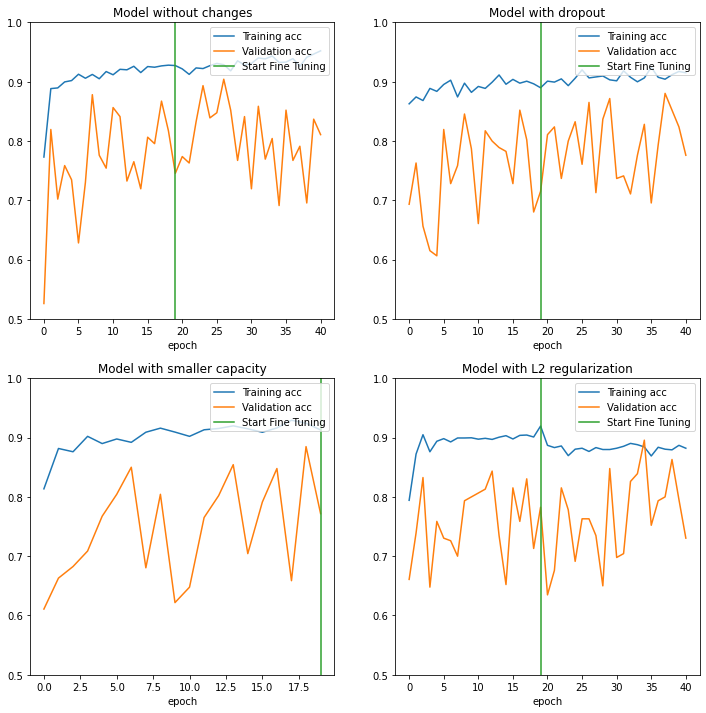

In [131]:
plt.figure(figsize=(12,12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.ylim([0.5, 1])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model without changes')
plt.xlabel('epoch')

plt.subplot(2, 2, 2)
plt.plot(acc_with_dropout, label='Training acc')
plt.plot(val_acc_with_dropout, label='Validation acc')
plt.ylim([0.5, 1])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model with dropout')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(acc_small_capacity, label='Training acc')
plt.plot(val_acc_small_capacity, label='Validation acc')
plt.ylim([0.5, 1])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model with smaller capacity')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(acc_with_reg, label='Training acc')
plt.plot(val_acc_with_reg, label='Validation acc')
plt.ylim([0.5, 1])
plt.plot([19,19],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model with L2 regularization')
plt.xlabel('epoch')
plt.show()

## To conclude:


*   All of the models don't have good performance, even on the training set we have only around 90% accuracy (where the model without changes have around 95% accuracy but it is overfitted on the training set for sure).
it may be caused by:

  1.   We don't have enough data on the training set
  2.   The task is to complex for our model and we need to build a more complex model with better abillity to generalize our training set


* All of the models validation-set graphs are very jumpy, maybe because we don't have enough data on our validation-set.
It can also indicate that our model is overfitted, or we need to reduce the learning rate, but because I chose Adam optimization, and 2 of the models handling overfitting, it is not the case.

* If we are looking at the loss graphs, all of them are pretty jumpy but only the model with dropout and the model with L2 reg, have a negative trend

* I would have continue with the model with L2 reg, because it seems to have the best fitting to the validation set and generelized the problem better than the other models, plus its val_loss graph is much more stable and less jumpy when comparing it to the other graphs, and the training loss seems not to go up or down after small number of epochs, so it means that the regularization is working pretty good!




